In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from sklearn.linear_model import LinearRegression

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [77]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [79]:
start_dt = '2021-05-01'
end_dt = '2021-05-07'

In [81]:
df = bigquery_client.query(f"""
select
    ssb_buyer_id
    , date
    , extract(hour from timestamp) as hour
    , extract(minute from timestamp) as minute
    , country
    , hosting_app_id
    , sponsored_app_id
    , request_host
    , exchange_id
    , carrier
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
    , sum(case when cleared > 0 then settlement_price else 0 end)*16/1000 as cost
from stats.rows 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10
""").to_dataframe()
df['date'] = df['date'].astype('datetime64')
df['ts_hour'] = df['date'] + pd.to_timedelta(df.hour, unit='h')
df['ts_min'] = df['ts_hour'] + pd.to_timedelta(df.minute, unit = 'm')
df['minute_of_day'] = df['hour']*60 + df['minute']

df['spend'] = df['spend'].astype('float')
df['cost'] = df['cost'].astype('float')
df['hosting_app_id'] = df['hosting_app_id'].astype('string')
df['sponsored_app_id'] = df['sponsored_app_id'].astype('string')

In [82]:
df = pd.merge(df, exchange, left_on = 'exchange_id', right_on = 'exchange_id', how = 'left')
df = pd.merge(df, buyer, left_on = 'ssb_buyer_id', right_on = 'Buyer ID', how = 'left')
df.dtypes

ssb_buyer_id               float64
date                datetime64[ns]
hour                         int64
minute                       int64
country                     object
hosting_app_id              string
sponsored_app_id            string
request_host                object
exchange_id                float64
carrier                     object
impressions                  int64
clicks                       int64
installs                     int64
spend                      float64
cost                       float64
ts_hour             datetime64[ns]
ts_min              datetime64[ns]
minute_of_day                int64
exchange_name               object
Buyer Name                  object
Buyer ID                   float64
dtype: object

Text(0.5, 1.0, 'morning network clicks by minute of day')

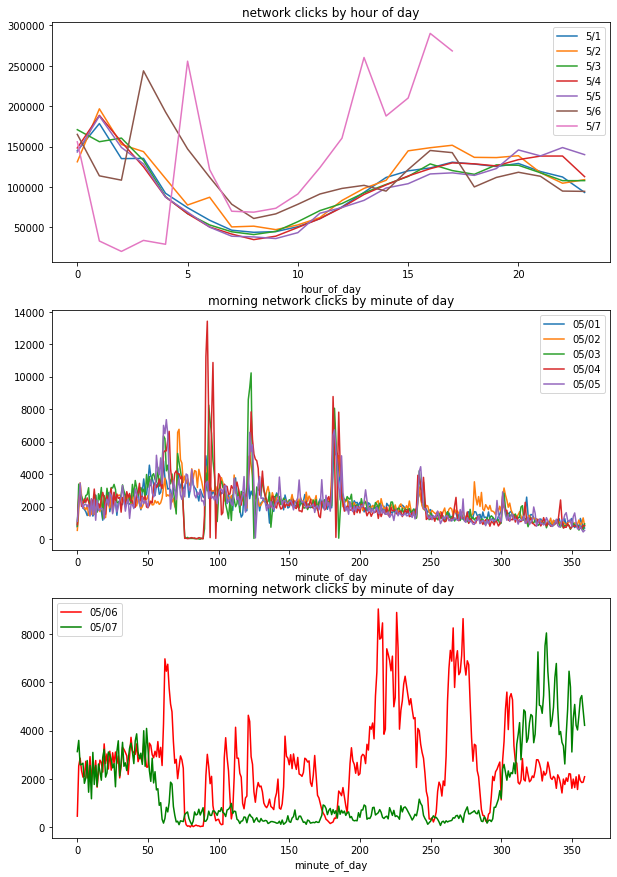

In [85]:
fig, ax = plt.subplots(3,1,figsize = (10,15))
ax[0].plot(df.pivot_table(values = ['clicks'], index = 'hour', columns = 'date', aggfunc = np.sum))
ax[0].legend(['5/1','5/2','5/3','5/4','5/5','5/6','5/7'])
ax[0].set_xlabel('hour_of_day')
ax[0].set_title('network clicks by hour of day')

morning_clicks = df[df.hour < 6].pivot_table(values = ['clicks'], index = ['minute_of_day'], columns = 'date', aggfunc = np.sum)
morning_clicks.columns = morning_clicks.columns.droplevel(0)
ax[1].plot(morning_clicks[morning_clicks.columns[:5]])
ax[1].legend([dt.strftime('%m/%d') for dt in morning_clicks.columns[:5]])
ax[1].set_xlabel('minute_of_day')
ax[1].set_title('morning network clicks by minute of day')

ax[2].plot(morning_clicks[['2021-05-06']], color = 'r')
ax[2].plot(morning_clicks[['2021-05-07']], color = 'g')
ax[2].legend([dt.strftime('%m/%d') for dt in morning_clicks.columns[5:]])
ax[2].set_xlabel('minute_of_day')
ax[2].set_title('morning network clicks by minute of day')

Text(0.5, 1.0, 'morning network imps by minute of day')

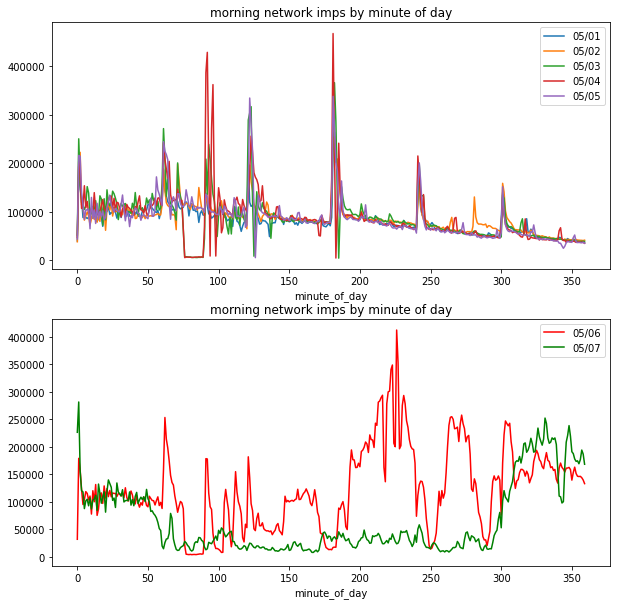

In [97]:
morning_imps = df[df.hour < 6].pivot_table(values = ['impressions'], index = ['minute_of_day'], columns = 'date', aggfunc = np.sum)
morning_imps.columns = morning_imps.columns.droplevel(0)

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(morning_imps[morning_imps.columns[:5]])
ax[0].legend([dt.strftime('%m/%d') for dt in morning_imps.columns[:5]])
ax[0].set_xlabel('minute_of_day')
ax[0].set_title('morning network imps by minute of day')

ax[1].plot(morning_imps[['2021-05-06']], color = 'r')
ax[1].plot(morning_imps[['2021-05-07']], color = 'g')
ax[1].legend([dt.strftime('%m/%d') for dt in morning_imps.columns[5:]])
ax[1].set_xlabel('minute_of_day')
ax[1].set_title('morning network imps by minute of day')

In [123]:
peak_time = df[(df.minute_of_day >= 180) & (df.minute_of_day <= 240) & (df.date.isin(['2021-05-06','2021-05-03']))]
agg_list = ['Buyer Name','exchange_name','carrier','request_host','country']
for i in agg_list:
    pvt = peak_time.pivot_table(values = 'clicks', index = i, columns = 'date', aggfunc = np.sum)
    pvt['increase'] = pvt['2021-05-06'] - pvt['2021-05-03']
    pvt['pct_increase'] = round(100*pvt['increase']/pvt[pvt.columns[0]],0).astype('string')+'%'
    pvt.columns = ['5/3','5/6','increase','% increase']
    print(pvt.sort_values('increase', ascending = False).head(20))

                      5/3       5/6  increase % increase
Buyer Name                                              
Digital Turbine   89456.0  209616.0  120160.0     134.0%
Mobilityware       3504.0    5984.0    2480.0      71.0%
Rollicgames        3120.0    4320.0    1200.0      38.0%
Moonactive          432.0    1552.0    1120.0     259.0%
Tripledot           848.0    1840.0     992.0     117.0%
Age of learning     448.0     992.0     544.0     121.0%
Buongiorno          192.0     704.0     512.0     267.0%
Unico Studio       1344.0    1824.0     480.0      36.0%
Apps_TR             176.0     592.0     416.0     236.0%
Wooga              2064.0    2432.0     368.0      18.0%
Tinuiti             544.0     832.0     288.0      53.0%
Fynd               1088.0    1312.0     224.0      21.0%
Etermax - Sales      16.0     144.0     128.0     800.0%
Zorka.mobi            0.0      96.0      96.0       inf%
DM.agency            32.0      48.0      16.0      50.0%
Gameofads             0.0      

In [124]:
peak_time = df[(df.minute_of_day >= 240) & (df.minute_of_day <= 300) & (df.date.isin(['2021-05-06','2021-05-03']))]
agg_list = ['Buyer Name','exchange_name','carrier','request_host','country']
for i in agg_list:
    pvt = peak_time.pivot_table(values = 'clicks', index = i, columns = 'date', aggfunc = np.sum)
    pvt['increase'] = pvt['2021-05-06'] - pvt['2021-05-03']
    pvt['pct_increase'] = round(100*pvt['increase']/pvt[pvt.columns[0]],0).astype('string')+'%'
    pvt.columns = ['5/3','5/6','increase','% increase']
    print(pvt.sort_values('increase', ascending = False).head(20))

                        5/3       5/6  increase % increase
Buyer Name                                                
Digital Turbine     60864.0  165152.0  104288.0     171.0%
Tripledot             528.0    2128.0    1600.0     303.0%
Wooga                 480.0    1744.0    1264.0     263.0%
Buongiorno            656.0    1568.0     912.0     139.0%
Tinuiti               384.0     912.0     528.0     138.0%
Moonactive            384.0     880.0     496.0     129.0%
Mobilityware         2848.0    3264.0     416.0      15.0%
Rollicgames          1936.0    2304.0     368.0      19.0%
Rocketlab             528.0     832.0     304.0      58.0%
Upify (Mobiground)     48.0     304.0     256.0     533.0%
Age of learning       192.0     336.0     144.0      75.0%
Etermax                16.0     160.0     144.0     900.0%
Tilting Point          96.0     208.0     112.0     117.0%
1screen               160.0     256.0      96.0      60.0%
Kwalee                128.0     208.0      80.0      62.